In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import os
# import codecs

In [2]:
target_url = ("/Users/devkrroy/Dev/Projects/snow/data/export3.xlsx")

In [3]:
df = pd.read_excel(target_url)

In [4]:
df.info()
print(df.columns.values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95373 entries, 0 to 95372
Data columns (total 28 columns):
Number                95373 non-null object
Assignment_group      95373 non-null object
Priority              95373 non-null object
State                 95373 non-null object
Category              93947 non-null object
Subcategory           61328 non-null object
Severity              95373 non-null object
Closure_CI            94492 non-null object
Location              95079 non-null object
Close_code            94559 non-null object
Configuration_item    95373 non-null object
Child_Incidents       95373 non-null int64
Contact_type          95373 non-null object
Duration              95373 non-null int64
Impact                95373 non-null object
Short_description     95373 non-null object
Created               95373 non-null datetime64[ns]
dates                 95373 non-null datetime64[ns]
date                  95373 non-null datetime64[ns]
day                   95373 non-n

In [ ]:
# plot few charts to understand the data
top_categories_df = df.groupby('Category').filter(lambda x: len(x) > 50)
top_categories_cnt = top_categories_df.Category.value_counts()

plt.plot

In [5]:
features = ['Number', 'Assignment_group', 'Priority', 'State', 'Category',
       'Subcategory', 'Severity', 'Closure_CI', 'Location', 'Close_code',
       'Configuration_item', 'Child_Incidents', 'Contact_type',
       'Duration', 'Impact', 'Short_description', 'Created']
df = df[features]

In [6]:
# print("Shape of input file", df.shape)
df = df.head(2000)

In [7]:
#Filter out some categories with instances < 50 for now , remove this filter in future
df = df.groupby("Category").filter(lambda x: len(x) > 50)
df = df.reset_index(drop = True)
df.Category.value_counts()

Server               458
Security             350
Network              333
Application          322
End User Services    246
EAI Interface        140
Name: Category, dtype: int64

In [8]:
# nltk text preprocessing
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import contractions

from sklearn import feature_extraction
# from nltk.tag import pos_tag

stop = stopwords.words('english')
lemmer=WordNetLemmatizer()

#extend stop words
new_stopwords = ['chw','edu','phx','vapp']
stop.extend(new_stopwords)

# to be tried - apply text collocations

def pre_process(text):
        
    # try to capture the IPs    
    ip_pattern = re.compile(r'([A-Za-z0-9]{2,}[-.]{1,1}){2,6}([A-Za-z0-9]*)')   
    ip = text.apply(lambda x: ' '.join(word for word in re.split('[\': (),]', x) if ip_pattern.match(word)))
    
    text = text.apply(lambda x: ' '.join(word.lower() for word in x.split()))  # lower case
#   text = text.apply(lambda x: ' '.join(contractions.fix(word) for word in x.split()))  # replace contractions

    text = text.str.replace('[^A-Za-z ]', ' ')  # remove non words
    
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in set(stop)]))   #stop
    text = text.apply(lambda x: ' '.join([lemmer.lemmatize(word, pos='v') for word in x.split()]))       #lemma
    text = text.apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1 ]))  #length >1

    return (text, ip)
    
normalized = pre_process(df['Short_description'])

In [9]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

tokenized_word=word_tokenize(normalized[0].to_string())

fdist = FreqDist(tokenized_word)
print(fdist)

<FreqDist with 3533 samples and 15836 outcomes>


In [10]:
fdist.most_common(50)

[('...', 43458),
 ('issue', 18550),
 ('unable', 16168),
 ('network', 13663),
 ('login', 12342),
 ('id', 11318),
 ('account', 10722),
 ('user', 10677),
 ('utilization', 9289),
 ('lock', 6667),
 ('set', 6318),
 ('desktop', 6288),
 ('threshold', 6064),
 ('nmscust', 5907),
 ('password', 5889),
 ('cerner', 5699),
 ('need', 5684),
 ('printer', 5671),
 ('mdf', 5595),
 ('reset', 5240),
 ('monitor', 4601),
 ('phone', 4516),
 ('device', 4365),
 ('cpu', 4228),
 ('able', 4222),
 ('ms', 4202),
 ('main', 4135),
 ('keyboard', 4045),
 ('pc', 4031),
 ('dev', 3647),
 ('application', 3633),
 ('ap', 3630),
 ('username', 3185),
 ('computer', 3170),
 ('helpdesk', 3005),
 ('zother', 2973),
 ('access', 2659),
 ('file', 2642),
 ('error', 2631),
 ('rt', 2577),
 ('mouse', 2505),
 ('work', 2485),
 ('wc', 2401),
 ('up', 2392),
 ('smart', 2364),
 ('rid', 2353),
 ('duo', 2258),
 ('kyocera', 2244),
 ('job', 2196),
 ('xl', 2182)]

In [10]:
df['Terms'] = normalized[0]
df['IPs'] = normalized[1]

In [11]:
df['IPs'][:10]

0    phx-vapp-689.chw.edu
1                        
2            PHX-VAPP-408
3                        
4                        
5                        
6                        
7           10.203.212.24
8    phx-vapp-842.chw.edu
9                        
Name: IPs, dtype: object

In [12]:
# import re

# print(re.split('[:\' ]', '\'phx-vapp-689.chw.edu\': Utilization is \'85.2\'. Threshold is set to \'Disk/File System/{C}/percent full >= 85\''))

# ci_pattern = re.compile(r'([A-Za-z0-9]{2,}[-.]{1,1}){2,6}([A-Za-z0-9]*)')

# print(ci_pattern.match('phx-vapp-238.chw.edu'))
# print(ci_pattern.match('CPU Utilization is '))
# print(ci_pattern.match('85.2'))
# print(ci_pattern.match('10.250.243.2'))
# print(ci_pattern.match('192.168.2.85)'))
# test = pd.DataFrame({'strings': ['...', 'a(b$c']})
# test.strings.str.replace('[^a-zA-Z ]', ' ')

In [13]:
# define a tokenizer which returns the set of tokens in the text that it is passed

def tokenize_only(text):
    # tokenize by  word 
    tokens = [word.lower() for word in nltk.word_tokenize(text) ]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(max_features=10000, max_df=0.8, min_df=0.0005,                                  
#                                   use_idf=True, tokenizer=word_tokenize, ngram_range=(1,3))
tfidf_vectorizer = TfidfVectorizer(max_features = 2000,                                  
                                  use_idf = True, tokenizer = word_tokenize, stop_words = stop, ngram_range = (1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(df['Terms'].values.astype('U'))

print(tfidf_matrix.shape)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 295 ms, sys: 3.17 ms, total: 299 ms
Wall time: 298 ms
(1849, 2000)


In [19]:
terms = tfidf_vectorizer.get_feature_names()
print(terms[100:200])

['ap', 'ap associate', 'ap associate controller', 'ap itc', 'ap itc sjpvh', 'ap mdf', 'ap mdf ponderosa', 'ap mdf vsmc', 'ap sjpvh', 'ap sjpvh ap', 'apache', 'apache unable', 'apache unable login', 'app', 'app cpu', 'app cpu utilization', 'app ping', 'app ping packet', 'app process', 'app process process', 'app utilization', 'app utilization threshold', 'application', 'application ii', 'application ii issue', 'application issue', 'application issue helpdesk', 'application lawson', 'application lawson ent', 'application server', 'application unable', 'application unable connect', 'application veracity', 'application veracity trigger', 'applications', 'apps', 'ask', 'ask user', 'associate', 'associate controller', 'attempt', 'attempt master', 'attempt master file', 'attempt result', 'attempt transcriptions', 'auth', 'auto', 'backup', 'backup overdue', 'bakersfield', 'bay', 'bay spi', 'baydsc', 'baydsc py', 'bgp', 'bgp peer', 'bgp peer establish', 'bk', 'bk hyb', 'bk mix', 'blood', 'bls',

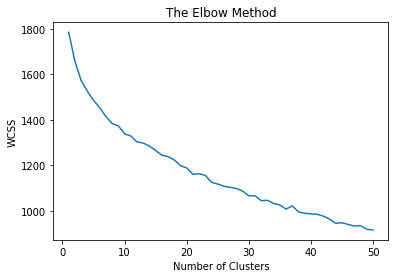

In [23]:
# Mini Batch K means
# from sklearn.cluster import MiniBatchKMeans
# num_clusters = 30
# km = MiniBatchKMeans(n_clusters = num_clusters, init = 'k-means++', n_init = 3, init_size = 300, batch_size = 100, random_state = 1)
# %time km.fit(tfidf_matrix)
# clusters = km.labels_.tolist()

# using elbow method to find optimum number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 51):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,51), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [29]:
# Save cluster in pickle file for future use
# import pickle

# pickle.dump(km, open('pkl/km_1.pkl', 'wb'))

In [30]:
# Create mapping of ngram features into clusters, 
# save into terms map object with key as cluster name (first feature in each cluster)
# terms = top 20 ngram features

order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
terms_map = pd.DataFrame(index=np.arange(0, num_clusters),columns=['terms','key'])    
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    #terms_map['key'] = i
    list = [] 
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end=',')
        list.append(terms[ind])
    for ind2 in order_centroids[i, :1]:
        terms_map.key.loc[i] = terms[ind2]

    str = ', '.join(list) 
    terms_map.terms.loc[i] = str
    print()
print(terms_map.shape)

Cluster 0: lock user, account lock user, lock user id, account, lock, account lock, user, user id, network account, network account lock, network, id, unlock account, unlock, account issue, unlock account issue, issue, issue resolve, resolve, account issue resolve,
Cluster 1: threshold set disk, disk file, set disk, set disk file, disk file system, percent full, file system, disk, percent, full, system, file system percent, system percent, system percent full, file, utilization threshold set, threshold set, utilization threshold, utilization, set,
Cluster 2: login, unable login, unable, login username, unable login username, username, network, network unable, network unable login, account, account unable, network account unable, account unable login, do, encryption unable login, encryption, encryption unable, password, network account, unable login uid,
Cluster 3: utilization, threshold set utilization, set utilization, cpu utilization threshold, cpu utilization, cpu, utilization thres